# Wine Pricing Study

#### Author: Steve Diamond [(GitHub)](https://github.com/StevenWDiamond)

### For Problem Statement, Executive Summary, Table of Contents and Data Dictionary, please link to [Data Cleaning / EDA Notebook](1_data_clean_eda.ipynb)

## KPrototypes Unsupervised Learning

### Rationale
We wanted to explore a cluster analysis for our data but, given that most of our data is dummy data, KPrototypes was the cluster analysis method that we chose to use. It allows us to input both categorical and non-categorical data. The this part of our study resulted in a new column of data which designated which cluster that row was assigned to and we used that column in two ways:
1. We added it to the DataFrame that was originally imported here to do additional EDA and understand how the clusters were made.
1. We also added it to our DataFrame with dummy columns to test against the non-clustered data in our modeling.

### Credits
This notebook was created based on code that was created by Julia Kelman.

In [1]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import sys
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

RANDOM_STATE = 42

random_state = RANDOM_STATE

In [2]:
# Import data
df = pd.read_csv('../data/clean_eda_data_kmodes.csv')

In [3]:
df.head()

,country,points,price,variety,high_q_term,region,vintage
0,Portugal,87,15.0,Portuguese Red,0,Douro,6
1,US,87,65.0,Pinot Noir,1,Willamette Valley,5
2,Spain,87,15.0,Tempranillo,0,Navarra,6
3,Italy,87,16.0,Frappato,0,Vittoria,4
4,US,87,19.0,Cabernet Sauvignon,0,Napa Valley,6


### Prepare Data for KPrototypes

This unsupervised learning model requires that we: 

#### Drop the target variable.

In [4]:
df.drop(columns='price', inplace=True)

#### Eliminate any missing pieces of data

In [5]:
df.fillna('Unknown', inplace = True)

#### Save the data as an array

In [6]:
X = np.array(df)

#### Ensure that all non-categorical data are integers

In [7]:
df['points'] = df['points'].astype(int)
df['high_q_term'] = df['high_q_term'].astype(int)
df['vintage'] = df['vintage'].astype(int)

### KPrototypes 

#### Run With A Range of Values for N-Clusters 
Using the loop below, we ran KPrototypes six times with the number of clusters being 2, 3, 4, 5, 6 and 7.

In [8]:
# Creating a loop to try our different number of clusters: 
kproto_costs = []
for n in range(2, 8):
    #do the clustering 
    kproto = KPrototypes(n_clusters=n, init='Huang', verbose=0, random_state=RANDOM_STATE, n_jobs=-1)
    clusters = kproto.fit_predict(X, categorical=[0, 2, 4])
    print(f'cost: {kproto.cost_}')
    print(f'iter: {kproto.n_iter_}')
    # get cost 
    cost = kproto.cost_
    #gather them
    kproto_costs.append((n, cost))

cost: 4198829.723889861
iter: 7
cost: 3893584.0840332774
iter: 8
cost: 3637906.632320284
iter: 9
cost: 3463560.5312949903
iter: 19
cost: 3329627.121495867
iter: 13
cost: 3273917.602012095
iter: 14


#### Graph the Results for Various N-Clusters Values

In [9]:
kproto_costs_copy = kproto_costs
kproto_costs_copy

[(2, 4198829.723889861),
 (3, 3893584.0840332774),
 (4, 3637906.632320284),
 (5, 3463560.5312949903),
 (6, 3329627.121495867),
 (7, 3273917.602012095)]

In [10]:
cost_list = [a_tuple[1] for a_tuple in kproto_costs_copy]

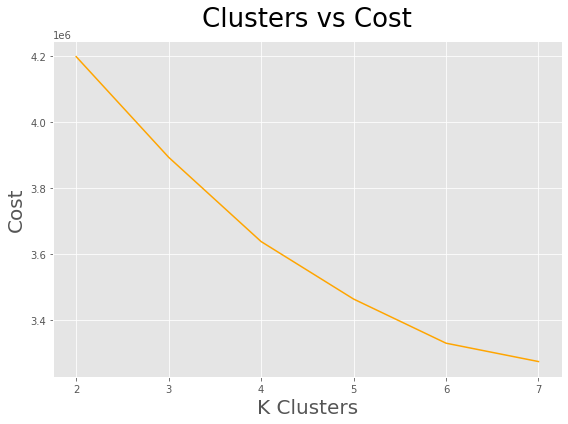

In [11]:
# Graphing 1-5 clusters for each initialization method

# establish figure and axes objects
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

# supply ax to the pandas plotting method
ax1 = sns.lineplot(x=[num1 for num1 in range(2,8)], y=cost_list,color='orange')



## Notice the change to the method names ##
ax.set_title('Clusters vs Cost', fontsize=26, pad=15)
ax.set_xlabel('K Clusters', fontsize=20)
ax.set_ylabel('Cost', fontsize=20)

fig.tight_layout();

**Interpretation**

- The turn in the line in our graph suggests that we have 6 clusters in our data.
- We will form a column which designates cluster for each row and merge this column with:
    - The DataFrame with our categorical data intact, which we will use to do additional [exploratory data analysis](data_clean_eda.ipynb).
    - The DataFrame with our dummied columns, which we will use in our [modeling](modeling.ipynb).
    
#### Create the Customer Clusters & Determine Cluster of Each Row

In [12]:
kproto_6 = KPrototypes(n_clusters=6, init='Huang', verbose=0, random_state=RANDOM_STATE, n_jobs=-1)
clusters = kproto_6.fit_predict(X, categorical=[0, 2, 4])
print(f'cost: {kproto_6.cost_}')

cost: 3329627.121495867


#### Add Clusters to DataFrames

1. Created Clusters DataFrame.
1. Created and exported new DataFrame which combined clusters column with data used in this process.
    * DataFrame will be used for EDA.
1. Created and exported new DataFrame which combined clusters column with modeling data.
    * DataFrame will be used for Modeling.

In [13]:
# Creating new cluster DataFrame and adding cluster predictions
clustersDf = pd.DataFrame(clusters)
clustersDf.columns = ['cluster_predicted']

# Merging new dataframe with the original and dropping additional index created
combinedDf = pd.concat([df, clustersDf], axis = 1).reset_index()

In [14]:
# verifying
combinedDf.head()

,index,country,points,variety,high_q_term,region,vintage,cluster_predicted
0,0,Portugal,87,Portuguese Red,0,Douro,6,4
1,1,US,87,Pinot Noir,1,Willamette Valley,5,4
2,2,Spain,87,Tempranillo,0,Navarra,6,4
3,3,Italy,87,Frappato,0,Vittoria,4,1
4,4,US,87,Cabernet Sauvignon,0,Napa Valley,6,5


In [15]:
# saving for use in additional EDA
combinedDf.to_csv('../data/non_dummied_plus_kprotos.csv',index=False)

In [16]:
# reading in dataframe with Dummy columns
df2 = pd.read_csv('../data/clean_eda_data.csv')

In [17]:
# combining this dataframe with the cluster predictions
combinedDf2 = pd.concat([df2, clustersDf], axis = 1).reset_index()
combinedDf2.drop(columns='index', inplace=True)

In [18]:
# verifying
combinedDf2.head()

,points,price,high_q_term,vintage,country_Argentina,country_Australia,country_Austria,country_Brazil,country_Bulgaria,country_Canada,...,region_Walla Walla Valley (OR),region_Walla Walla Valley (WA),region_Washington,region_Western Cape,region_Willamette Valley,region_Yakima Valley,region_Yarra Valley,region_Yorkville Highlands,region_Yountville,cluster_predicted
0,87,15.0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,87,65.0,1,5,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4
2,87,15.0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,87,16.0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,87,19.0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [19]:
# Saving for use in modeling
combinedDf2.to_csv('../data/dummied_plus_kproto.csv',index=False)

## Next
- Return to [Data Cleaning / EDA Notebook](1_data_clean_eda.ipynb) for KPrototypes EDA.
- View [Modeling Notebook](3_modeling.ipynb).